In [ ]:
!pip install pyradiomics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 42.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (

In [ ]:
!pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Import Library

In [ ]:
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt
import os
import os.path
import radiomics
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, Conv2DTranspose, UpSampling2D, Input, ZeroPadding2D, BatchNormalization, Activation, AveragePooling2D
from keras.optimizers import Adam, Adamax, Nadam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
import seaborn as sns

#Helper

In [ ]:
def nii_reader(path):
    reader = sitk.ImageFileReader()
    reader.SetImageIO("NiftiImageIO")
    reader.SetFileName(path)
    img = reader.Execute();
    return img

In [ ]:
def mask_operations(mask, patient_id, path_binmask, dataset, low_thresh = 0, up_thresh = 0):
    ##### Note : Mask is not binarize --> You need to binarize it
    ##### Step 1 : Binary threshold
#    mask_array = sitk.GetArrayFromImage(mask)
    btif=sitk.BinaryThresholdImageFilter()
    btif.SetLowerThreshold(low_thresh) # lower value to set as background = 0 : Inside value
    btif.SetUpperThreshold(up_thresh) # upper value, if you set 2: label 3 will be visible, if you set 1, label 2 and 3 visible
    btif.SetInsideValue(0)
    btif.SetOutsideValue(1)
    mask = btif.Execute(mask)
    ##### Step 2 : Morphological closing --> fill the pixels with 0 inside ROI with 1 (fill the holes inside the ROI)
    closing = sitk.BinaryMorphologicalClosingImageFilter()
    mask =closing.Execute(mask)
#    binMask = sitk.GetArrayFromImage(mask) ### To check the mask's pixel values

    ### save image to check later
    binmask_path = path_binmask + patient_id + '_binMask.nii.gz'
    sitk.WriteImage(mask, binmask_path)


    return mask

In [ ]:
def create_patches(path, patient, dataset):
    low_threshold = 0
    up_threshold = 0
    # Define the image paths [images and masks]
    img_path=os.path.join(path,"Images","%s.nii.gz" %(patient)) # Directory of image nii
    gt_path =os.path.join(path, "Contours","%s.nii.gz" %(patient)) # Directory of Ground truth

    print(f"Image path {img_path}")
    # Load the images with sitk
    img = nii_reader(img_path)
    gt_img = nii_reader(gt_path)

    # mask operations
    # Combine 2 labels together
    binMask_path = "/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_binmask/"
    gt_img_l1 = mask_operations(gt_img, patient, binMask_path, dataset, low_threshold, up_threshold)  # make the segmentation 1-layer only


    # ED
    (bbox, corrected_mask) = radiomics.imageoperations.checkMask(img, gt_img_l1, correctMask=True )
    (cropped_img, cropped_gt) = radiomics.imageoperations.cropToTumorMask(img, gt_img_l1, boundingBox=bbox)
    (cropped_gt_scar, a) = radiomics.imageoperations.cropToTumorMask(gt_img, gt_img_l1, boundingBox=bbox ) # segmentation: LV blood pool, scar and MVO area, MYO
    return cropped_img, cropped_gt, cropped_gt_scar

In [ ]:
def preprocess_files(path_training, minf_cohort, save_path, cohort_name):
    dataset="EMIDEC"
    patient_ids=[]
    Label = []
    images = []  # store the images and the segmentations for ED and ES separately - for the future experiments
    segs =[]
    segs_scar =[]
    shape_img=[]
    shape_gt = []

    #save_path = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped"
    #data = np.zeros((nb_patients,428,512,25)) # PREPROCESSING NEEDED : BOUNDARY BOX


    for j in range(len(minf_cohort)):
          path_files = os.path.join(path_training, minf_cohort[j] )
          patient_id = minf_cohort[j]

          print('%s with %s'%(patient_id, cohort_name))

          [cropped_img, cropped_gt, cropped_gt_scar] = create_patches(path_files, patient_id, dataset)

          #
          cropped_arr =  sitk.GetArrayFromImage(cropped_img)
          cropped_gt_arr = sitk.GetArrayFromImage(cropped_gt)

          #################################################################################################
          # multiply mask and ground truth to remove LV blood pool from the image = only for EMIDEC dataset
          #multiply = sitk.MultiplyImageFilter()
          #cropped_gt_casted = sitk.Cast(cropped_gt, sitk.sitkFloat64)

          #new_img = multiply.Execute(cropped_img, cropped_gt_casted)

          #new_img_arr = sitk.GetArrayFromImage(new_img)
          #################################################################################################

          # Multiply scar segmentation with 1-label segmentation = Removes LV Blood pool from the segmentation
          # This part is for visualization purposes


          filename_img = os.path.join(save_path,"%s.nii.gz" %(patient_id))
          filename_gt = os.path.join(save_path,"%s_gt.nii.gz" %(patient_id))
          #filename_img_org = os.path.join(save_path,"%s_org.nii.gz" %(patient_id))
          filename_gt_scar = os.path.join(save_path,"%s_gt_scar.nii.gz" %(patient_id))
          images.append(filename_img)
          segs.append(filename_gt)
          segs_scar.append(filename_gt_scar)

          sitk.WriteImage(cropped_img, filename_img)
          #sitk.WriteImage(cropped_img, filename_img_org)
          sitk.WriteImage(cropped_gt, filename_gt)

          sitk.WriteImage(cropped_gt_scar, filename_gt_scar)

          shape_img.append(cropped_arr.shape)
          shape_gt.append(cropped_gt_arr.shape)

          if cohort_name =="MINF":
                value = 1
          else:
                value = 0

          Label.append(value)
         # patient_ids.append(patient_id)


    return images, segs, segs_scar, shape_img, shape_gt, Label

#Preperated Data

In [ ]:
emidec_path = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training"
save_crop_emidec = "/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/"
path_files = os.listdir(emidec_path)

folders =  [f for f in os.listdir(emidec_path) if not f.endswith('.txt')]# the others are the patient folders
folders.sort()
healthy_cohort =  [param for param in folders if param.split("_")[1].startswith('N')] # the ones start with N (after _) are healthy
minf_cohort = [param for param in folders if param.split("_")[1].startswith('P')] # the ones start with P are MINF
nb_healthy_emidec =  len(healthy_cohort)
nb_minf_emidec = len(minf_cohort)

##Visualization data

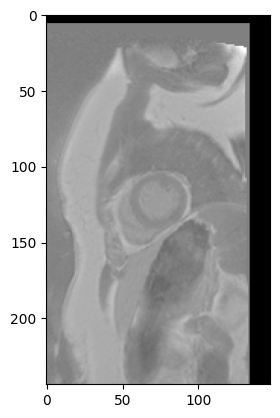

In [ ]:
#Normal
i = 0
#for i in range(5):
patient_id = healthy_cohort[i]
path_file = os.path.join(emidec_path, patient_id )
img_path = os.path.join(path_file, "Images","%s.nii.gz" %(patient_id))
nii_data1 = nii_reader(img_path)
gt_path =os.path.join(path_file, "Contours","%s.nii.gz" %(patient_id))
nii_data = nii_reader(gt_path)
before = sitk.GetArrayFromImage(nii_data1)
plt.imshow(before[3,:,:], cmap='gray')
plt.show()

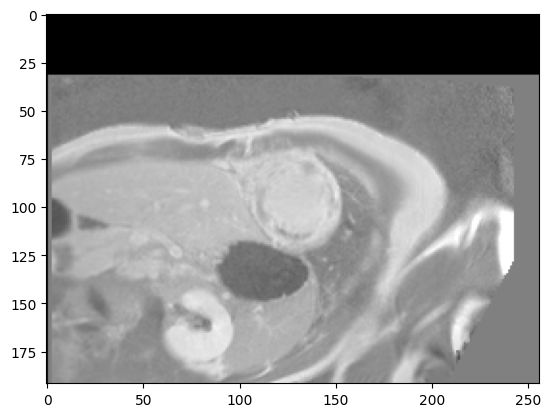

In [ ]:
#mycocardial
i = 0
# for i in range(5):
patient_id = minf_cohort[i]
path_file = os.path.join(emidec_path, patient_id )
img_path = os.path.join(path_file, "Images","%s.nii.gz" %(patient_id))
nii_data1 = nii_reader(img_path)
gt_path =os.path.join(path_file, "Contours","%s.nii.gz" %(patient_id))
nii_data = nii_reader(gt_path)
before = sitk.GetArrayFromImage(nii_data1)
plt.imshow(before[3,:,:], cmap='gray')
plt.show()

#Crop Data to LV

In [ ]:
images_nor, segs_nor, segs_scar_nor, shape_img_nor, shape_gt_nor, label_nor= preprocess_files(emidec_path, healthy_cohort, save_crop_emidec, cohort_name='NOR')
images_minf, segs_minf, segs_scar_minf, shape_img_minf, shape_gt_minf, label_minf= preprocess_files(emidec_path, minf_cohort, save_crop_emidec, cohort_name='MINF')

Case_N006 with NOR
Image path /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_N006/Images/Case_N006.nii.gz
Case_N012 with NOR
Image path /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_N012/Images/Case_N012.nii.gz
Case_N013 with NOR
Image path /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_N013/Images/Case_N013.nii.gz
Case_N014 with NOR
Image path /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_N014/Images/Case_N014.nii.gz
Case_N016 with NOR
Image path /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_N016/Images/Case_N016.nii.gz
Case_N018 with NOR
Image path /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_N018/Images/Case_N018.nii.gz
Case_N020 with NOR
Image path /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_N020/Images/Case_N020.nii.gz
Case_N023 with NOR
Image path /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_N023/Images/Case_N023.nii.gz
Case_N024 with NOR
Image path /content/gdrive/My

In [ ]:
images_nor[:5]

['/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/Case_N006.nii.gz',
 '/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/Case_N012.nii.gz',
 '/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/Case_N013.nii.gz',
 '/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/Case_N014.nii.gz',
 '/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/Case_N016.nii.gz']

##Visualization data

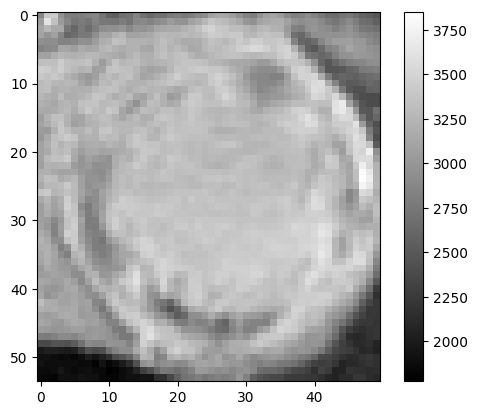

In [ ]:
#Myocardial
img_minf_org = nii_reader(images_minf[0])
img_minf = sitk.GetArrayFromImage(img_minf_org)
plt.imshow(img_minf[3,:,:], cmap="gray")
plt.colorbar()
plt.show()

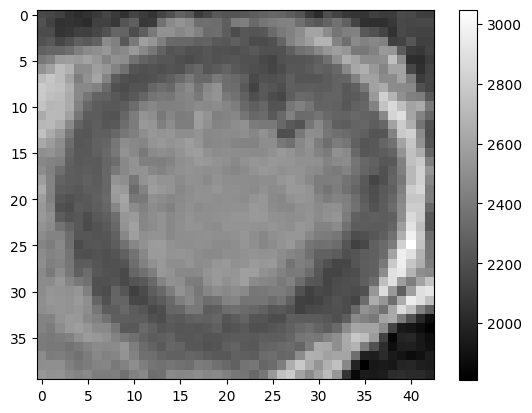

In [ ]:
#Normal
img_minf_org = nii_reader(images_nor[0])
img_minf = sitk.GetArrayFromImage(img_minf_org)
plt.imshow(img_minf[3,:,:], cmap="gray")
plt.colorbar()
plt.show()

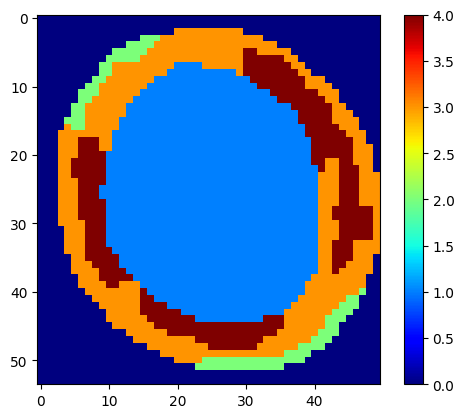

Cohort : 1


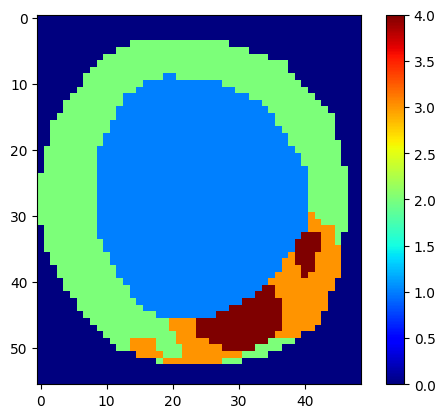

Cohort : 1


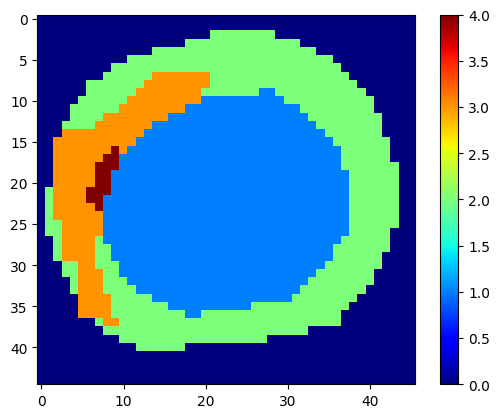

Cohort : 1


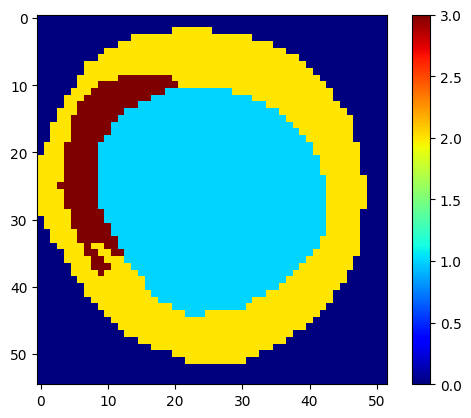

Cohort : 1


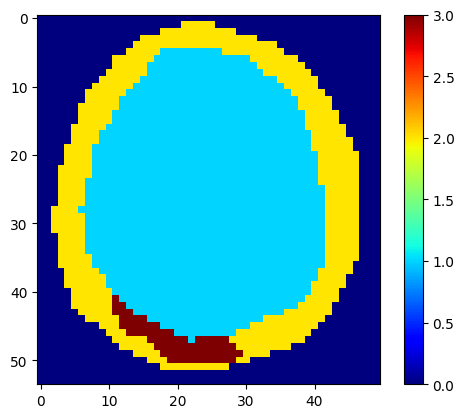

Cohort : 1
Note: 0 = Healthy and 1 = MINF


In [ ]:
# Myocardial
for i in range(5):
  gt_minf_org = nii_reader(segs_scar_minf[i])
  gt_minf = sitk.GetArrayFromImage(gt_minf_org)
  plt.imshow(gt_minf[3,:,:], cmap="jet")
  plt.colorbar()
  plt.show()
  print(f"Cohort : {label_minf[i]}")
print("Note: 0 = Healthy and 1 = MINF")

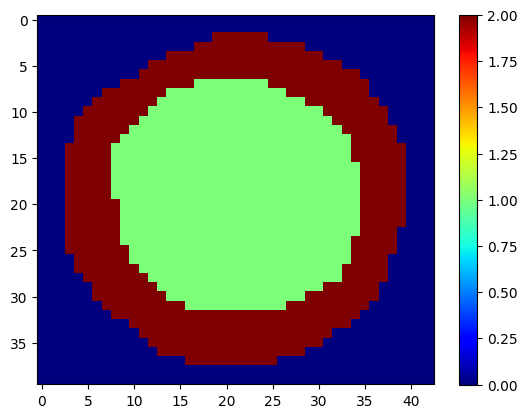

Cohort : 0


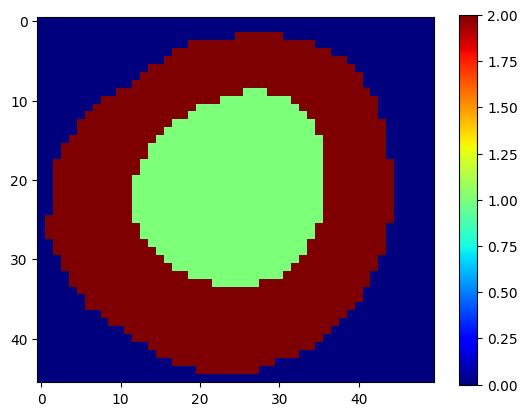

Cohort : 0


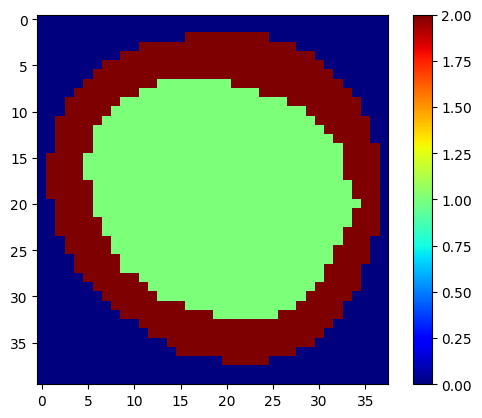

Cohort : 0


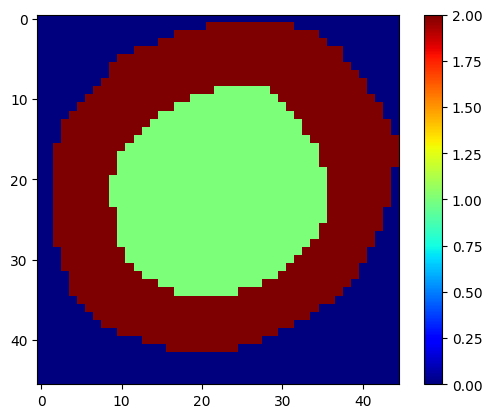

Cohort : 0


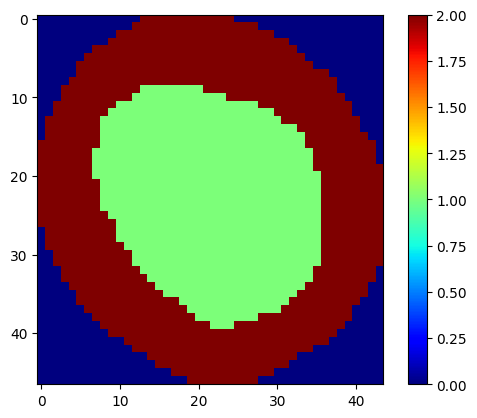

Cohort : 0
Note: 0 = Healthy and 1 = MINF


In [ ]:
# Normal
for i in range(5):
  gt_nor_org = nii_reader(segs_scar_nor[i])
  gt_nor = sitk.GetArrayFromImage(gt_nor_org)
  plt.imshow(gt_nor[3,:,:], cmap="jet")
  plt.colorbar()
  plt.show()
  print(f"Cohort : {label_nor[i]}")
print("Note: 0 = Healthy and 1 = MINF")

#Preprocessing

In [ ]:
images = [*segs_scar_nor, *segs_scar_minf ,]
Label = [*label_nor, *label_minf]

In [ ]:
images[:5]

['/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/Case_N006_gt_scar.nii.gz',
 '/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/Case_N012_gt_scar.nii.gz',
 '/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/Case_N013_gt_scar.nii.gz',
 '/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/Case_N014_gt_scar.nii.gz',
 '/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/Case_N016_gt_scar.nii.gz']

In [ ]:
# value image into list
list_img = []
for item in images:
  img_org = nii_reader(item)
  img = sitk.GetArrayFromImage(img_org)
  img = img.astype(np.float32)
  list_img.append(img)

In [ ]:
# reshape image with same dimension
max_shape = tuple(max(dim) for dim in zip(*(d.shape for d in list_img)))
padded_data = [np.pad(d, pad_width=((0, max_shape[0]-d.shape[0]), (0, max_shape[1]-d.shape[1]), (0, max_shape[2]-d.shape[2])), mode='constant') for d in list_img]
for i in range(5):
  print(padded_data[i].shape)

(10, 61, 59)
(10, 61, 59)
(10, 61, 59)
(10, 61, 59)
(10, 61, 59)


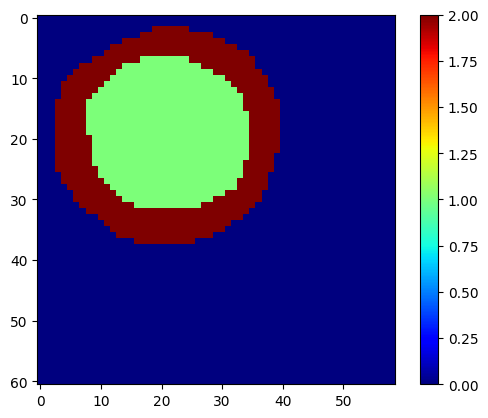

In [ ]:
#check image after reshape
cek = padded_data[0]
plt.imshow(cek[3,:,:], cmap="jet")
plt.colorbar()
plt.show()

In [ ]:
# list to array
temp = np.array([])
temp = np.stack(padded_data, axis=0)
temp.shape

(100, 10, 61, 59)

In [ ]:
files = temp
files.shape

(100, 10, 61, 59)

In [ ]:
import imgaug.augmenters as iaa

# Define augmentation pipeline
# flip vertical
augmenter1 = iaa.Sequential([
    iaa.Fliplr(1.0),
])
augmented1 = augmenter1(images=temp)
files = np.vstack((files, augmented1))

# flip horizontal
augmenter2 = iaa.Sequential([
    iaa.Flipud(1.0),
])
augmented2 = augmenter2(images=temp)
files = np.vstack((files, augmented2))

# flip vertical dan horizontal
augmenter3 = iaa.Sequential([
    iaa.Fliplr(1.0),
    iaa.Flipud(1.0),
])
augmented3 = augmenter3(images=temp)
files = np.vstack((files, augmented3))

# crop 10%
augmenter4 = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)),
])
augmented4 = augmenter4(images=temp)
files = np.vstack((files, augmented4))

# # Resize each image to something between 50 and 100% of its original size
# augmenter5 = iaa.Sequential([
#     iaa.AddElementwise((0, 1)),
# ])
# augmented5 = augmenter5(images=temp)
# files = np.vstack((files, augmented5))

# flip vertical and crop 10%
augmenter5 = iaa.Sequential([
    iaa.Fliplr(1.0),
    iaa.Crop(percent=(0, 0.1)),
])
augmented5 = augmenter5(images=temp)
files = np.vstack((files, augmented5))

# flip horizontal and crop 10%
augmenter6 = iaa.Sequential([
    iaa.Flipud(1.0),
    iaa.Crop(percent=(0, 0.1)),
])
augmented6 = augmenter6(images=temp)
files = np.vstack((files, augmented6))

# flip vertical, horizontal and crop 10%
augmenter7 = iaa.Sequential([
    iaa.Fliplr(1.0),
    iaa.Flipud(1.0),
    iaa.Crop(percent=(0, 0.1)),
])
augmented7 = augmenter7(images=temp)
files = np.vstack((files, augmented7))

files.shape

(800, 10, 61, 59)

In [ ]:
lb = int(files.shape[0] / 100)
lb

8

In [ ]:
len(Label)

100

In [ ]:
Label = Label * lb
len(Label)

800

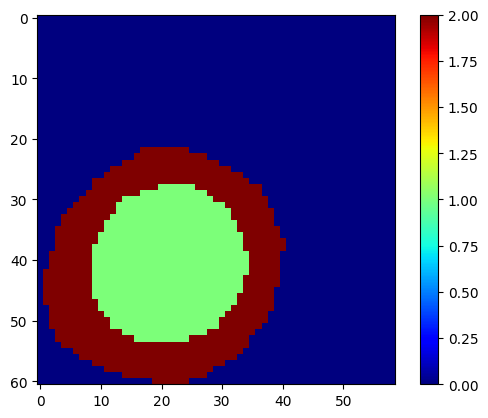

In [ ]:
#cek data augmented
cek = files[300]
plt.imshow(cek[3,:,:], cmap="jet")
plt.colorbar()
plt.show()

In [ ]:
max_value = np.max(files)
max_value

4.0

In [ ]:
from sklearn.model_selection import train_test_split

train_files, test_files, train_labels,  test_labels = train_test_split(files, Label, test_size=0.2, random_state=100)
train_files, val_files, train_labels,  val_labels = train_test_split(train_files, train_labels, test_size=0.2, random_state=100)

In [ ]:
# Normalisasi Data
# train_files = np.transpose(train_files, (0, 2, 3, 1))
# val_files = np.transpose(val_files, (0, 2, 3, 1))
train_files = train_files / max_value
val_files = val_files / max_value
test_files = test_files / max_value

In [ ]:
train_files.shape

(512, 10, 61, 59)

In [ ]:
val_files.shape

(128, 10, 61, 59)

In [ ]:
n_classes = 2
train_label = np_utils.to_categorical(train_labels, n_classes)
val_label = np_utils.to_categorical(val_labels, n_classes)
test_label = np_utils.to_categorical(test_labels, n_classes)
train_label[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
val_label[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
train_label.shape

(512, 2)

In [ ]:
val_label.shape

(128, 2)

In [ ]:
input_shape = tuple(max_shape)
# input_shape = tuple(sorted(max_shape, reverse=True))
input_shape

(10, 61, 59)

In [ ]:
target_names = ["class {}".format(i) for i in range(n_classes)]

#CNN

In [ ]:
model_cnn = keras.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation="softmax"),
    ]
)
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_189"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_378 (Conv2D)         (None, 8, 59, 32)         17024     
                                                                 
 max_pooling2d_378 (MaxPooli  (None, 4, 29, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_379 (Conv2D)         (None, 2, 27, 64)         18496     
                                                                 
 max_pooling2d_379 (MaxPooli  (None, 1, 13, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_189 (Flatten)       (None, 832)               0         
                                                                 
 dense_378 (Dense)           (None, 64)             

In [ ]:
history_cnn = model_cnn.fit(
    # swap `val_files` and `train_label`
    x=train_files,    # `Input data` with shape (train_size,32,32,3)
    y=train_label,    # `Input data labels` with shape (train_size,2)
    epochs=100,
    batch_size=32,    # If unspecified, batch_size will default to 32
    validation_data=(
        val_files,    # `Valid data` with shape (val_size,32,32,3)
        val_label     # `Valid data labels` with shape (val_size,2)
    )
)

Epoch 1/100
16/16 [==============================] - 3s 91ms/step - loss: 0.6084 - accuracy: 0.6719 - val_loss: 0.5640 - val_accuracy: 0.6250
Epoch 2/100
16/16 [==============================] - 1s 77ms/step - loss: 0.5233 - accuracy: 0.7109 - val_loss: 0.5217 - val_accuracy: 0.6797
Epoch 3/100
16/16 [==============================] - 1s 69ms/step - loss: 0.5092 - accuracy: 0.7305 - val_loss: 0.5631 - val_accuracy: 0.6250
Epoch 4/100
16/16 [==============================] - 1s 70ms/step - loss: 0.4901 - accuracy: 0.7598 - val_loss: 0.5021 - val_accuracy: 0.7500
Epoch 5/100
16/16 [==============================] - 1s 70ms/step - loss: 0.4646 - accuracy: 0.7637 - val_loss: 0.5132 - val_accuracy: 0.7656
Epoch 6/100
16/16 [==============================] - 2s 100ms/step - loss: 0.4488 - accuracy: 0.7871 - val_loss: 0.5077 - val_accuracy: 0.7812
Epoch 7/100
16/16 [==============================] - 2s 125ms/step - loss: 0.4109 - accuracy: 0.8105 - val_loss: 0.4837 - val_accuracy: 0.7734
Epoc

In [ ]:
score_cnn = model_cnn.evaluate(val_files, val_label, verbose=0)
print("Test loss:", score_cnn[0])
print("Test accuracy:", score_cnn[1])

Test loss: 0.7068873643875122
Test accuracy: 0.921875


##Training

16/16 [==============================] - 0s 17ms/step


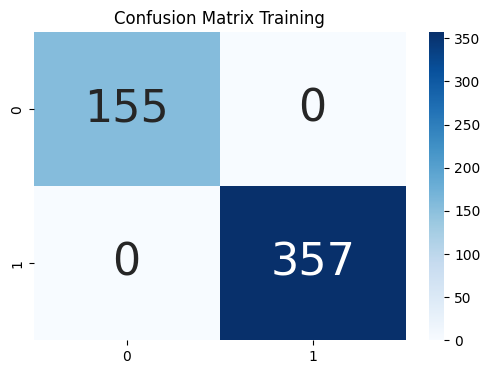

In [ ]:
#train
train_predictions = model_cnn.predict(train_files)
train_pred_label = np.argmax(train_predictions, axis=1)
train_test_label = np.argmax(train_label , axis=1)
train_cm   = confusion_matrix(train_test_label, train_pred_label)
plt.figure(figsize=(6, 4))
sns.heatmap(train_cm , annot=True, fmt='d', cmap='Blues', annot_kws={"size": 32})
plt.title('Confusion Matrix Training')
plt.show()

In [ ]:
train_accuracy = (train_cm[0, 0]+train_cm[1, 1]) / (train_cm[0, 0] + train_cm[0, 1] + train_cm[1, 0] + train_cm[1, 1])
train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1])
train_sensitivity = train_cm[1, 1] / (train_cm[1, 0] + train_cm[1, 1])

print("Training Accuracy:", train_accuracy)
print("Training Specificity:", train_specificity)
print("Training Sensitivity:", train_sensitivity)

Training Accuracy: 1.0
Training Specificity: 1.0
Training Sensitivity: 1.0


##Validation

4/4 [==============================] - 0s 16ms/step


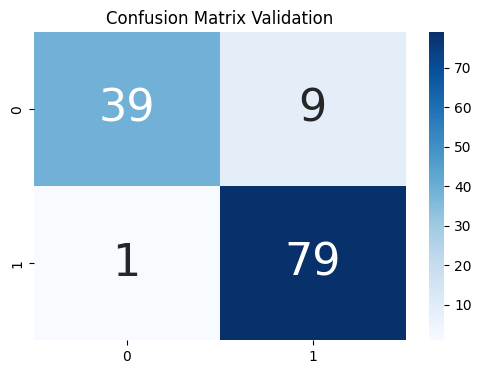

In [ ]:
#val
val_predictions = model_cnn.predict(val_files)
val_pred_label = np.argmax(val_predictions , axis=1)
val_test_label = np.argmax(val_label , axis=1)
val_cm  = confusion_matrix(val_test_label, val_pred_label)
plt.figure(figsize=(6, 4))
sns.heatmap(val_cm , annot=True, fmt='d', cmap='Blues', annot_kws={"size": 32})
plt.title('Confusion Matrix Validation')
plt.show()

In [ ]:
val_accuracy = (val_cm[0, 0]+val_cm[1, 1]) / (val_cm[0, 0] + val_cm[0, 1] + val_cm[1, 0] + val_cm[1, 1])
val_specificity = val_cm[0, 0] / (val_cm[0, 0] + val_cm[0, 1])
val_sensitivity = val_cm[1, 1] / (val_cm[1, 0] + val_cm[1, 1])

print("Validation Accuracy:", val_accuracy)
print("Validation Specificity:", val_specificity)
print("Validation Sensitivity:", val_sensitivity)

Validation Accuracy: 0.921875
Validation Specificity: 0.8125
Validation Sensitivity: 0.9875


##Testing

5/5 [==============================] - 0s 17ms/step


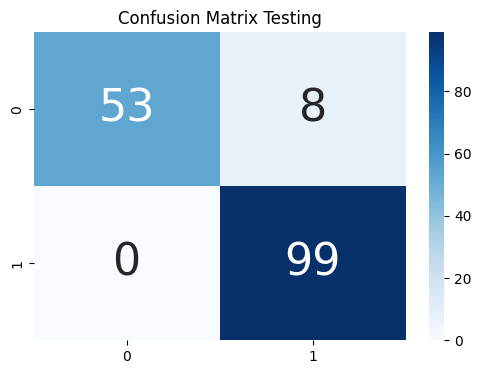

In [ ]:
#test
test_predictions = model_cnn.predict(test_files)
test_pred_label = np.argmax(test_predictions , axis=1)
test_test_label = np.argmax(test_label , axis=1)
test_cm  = confusion_matrix(test_test_label, test_pred_label)
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm , annot=True, fmt='d', cmap='Blues', annot_kws={"size": 32})
plt.title('Confusion Matrix Testing')
plt.show()

In [ ]:
test_accuracy = (test_cm[0, 0]+test_cm[1, 1]) / (test_cm[0, 0] + test_cm[0, 1] + test_cm[1, 0] + test_cm[1, 1])
test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1])
test_sensitivity = test_cm[1, 1] / (test_cm[1, 0] + test_cm[1, 1])

print("Testing Accuracy:", test_accuracy)
print("Testing Specificity:", test_specificity)
print("Testing Sensitivity:", test_sensitivity)

Testing Accuracy: 0.95
Testing Specificity: 0.8688524590163934
Testing Sensitivity: 1.0


#Hyperparameter

In [ ]:
# Create the CNN model
def create_model_cnn(optimizer, learning_rate):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer(learning_rate=learning_rate), metrics=['accuracy'])
    return model

# Create the KerasClassifier wrapper
model = KerasClassifier(build_fn=create_model_cnn, verbose=0)

# Define the hyperparameters grid
param_grid = {
    'optimizer': [Adam, Adamax, Nadam], #['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    'batch_size': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [100]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(train_files, train_label)

# Print the best hyperparameters and accuracy
print("Best Accuracy: {:.2f}%".format(grid_result.best_score_ * 100))
print("Best Hyperparameters:", grid_result.best_params_)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<ipython-input-89-95e154f9089f>:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model_cnn, verbose=0)


Best Accuracy: 93.36%
Best Hyperparameters: {'batch_size': 128, 'epochs': 100, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.legacy.adam.Adam'>}
0.917957 (0.004987) with: {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.legacy.adam.Adam'>}
0.927738 (0.002665) with: {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.legacy.adamax.Adamax'>}
0.898441 (0.011988) with: {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.legacy.nadam.Nadam'>}
0.720594 (0.046171) with: {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.legacy.adam.Adam'>}
0.872985 (0.029507) with: {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.legacy.adamax.Adamax'>}
0.757734 (0.029911) with: {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.

##Training

16/16 [==============================] - 0s 17ms/step


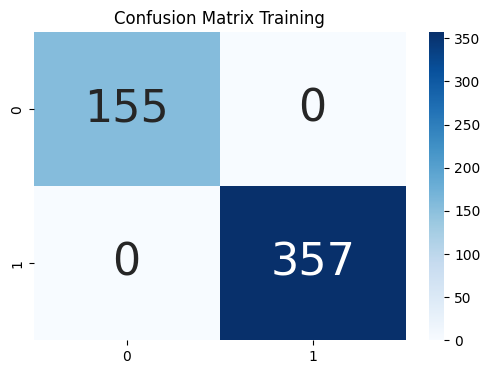

In [ ]:
#train
train_predictions = model_cnn.predict(train_files)
train_pred_label = np.argmax(train_predictions, axis=1)
train_test_label = np.argmax(train_label , axis=1)
train_cm   = confusion_matrix(train_test_label, train_pred_label)
plt.figure(figsize=(6, 4))
sns.heatmap(train_cm , annot=True, fmt='d', cmap='Blues', annot_kws={"size": 32})
plt.title('Confusion Matrix Training')
plt.show()

In [ ]:
train_accuracy = (train_cm[0, 0]+train_cm[1, 1]) / (train_cm[0, 0] + train_cm[0, 1] + train_cm[1, 0] + train_cm[1, 1])
train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1])
train_sensitivity = train_cm[1, 1] / (train_cm[1, 0] + train_cm[1, 1])

print("Training Accuracy:", train_accuracy)
print("Training Specificity:", train_specificity)
print("Training Sensitivity:", train_sensitivity)

Training Accuracy: 1.0
Training Specificity: 1.0
Training Sensitivity: 1.0


##Validation

4/4 [==============================] - 0s 16ms/step


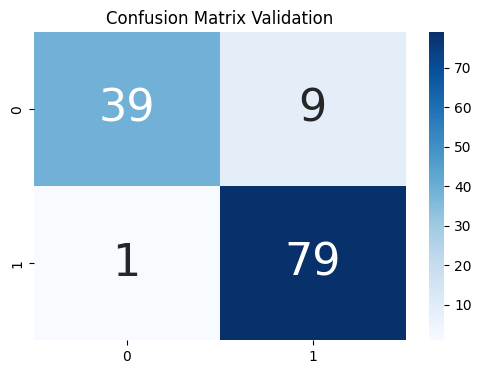

In [ ]:
#val
val_predictions = model_cnn.predict(val_files)
val_pred_label = np.argmax(val_predictions , axis=1)
val_test_label = np.argmax(val_label , axis=1)
val_cm  = confusion_matrix(val_test_label, val_pred_label)
plt.figure(figsize=(6, 4))
sns.heatmap(val_cm , annot=True, fmt='d', cmap='Blues', annot_kws={"size": 32})
plt.title('Confusion Matrix Validation')
plt.show()

In [ ]:
val_accuracy = (val_cm[0, 0]+val_cm[1, 1]) / (val_cm[0, 0] + val_cm[0, 1] + val_cm[1, 0] + val_cm[1, 1])
val_specificity = val_cm[0, 0] / (val_cm[0, 0] + val_cm[0, 1])
val_sensitivity = val_cm[1, 1] / (val_cm[1, 0] + val_cm[1, 1])

print("Validation Accuracy:", val_accuracy)
print("Validation Specificity:", val_specificity)
print("Validation Sensitivity:", val_sensitivity)

Validation Accuracy: 0.921875
Validation Specificity: 0.8125
Validation Sensitivity: 0.9875


##Testing

5/5 [==============================] - 0s 17ms/step


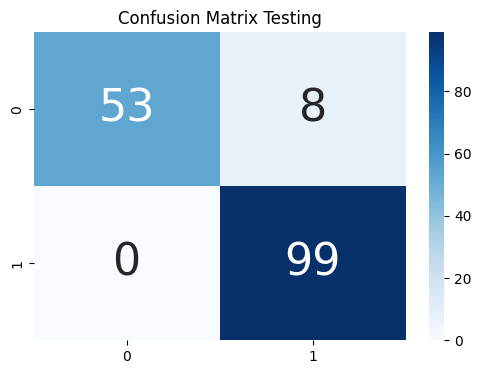

In [ ]:
#test
test_predictions = model_cnn.predict(test_files)
test_pred_label = np.argmax(test_predictions , axis=1)
test_test_label = np.argmax(test_label , axis=1)
test_cm  = confusion_matrix(test_test_label, test_pred_label)
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm , annot=True, fmt='d', cmap='Blues', annot_kws={"size": 32})
plt.title('Confusion Matrix Testing')
plt.show()

In [ ]:
test_accuracy = (test_cm[0, 0]+test_cm[1, 1]) / (test_cm[0, 0] + test_cm[0, 1] + test_cm[1, 0] + test_cm[1, 1])
test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1])
test_sensitivity = test_cm[1, 1] / (test_cm[1, 0] + test_cm[1, 1])

print("Testing Accuracy:", test_accuracy)
print("Testing Specificity:", test_specificity)
print("Testing Sensitivity:", test_sensitivity)

Testing Accuracy: 0.95
Testing Specificity: 0.8688524590163934
Testing Sensitivity: 1.0
